In [1]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from matplotlib.pyplot import imshow

# Loading data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import data from Google Drive

cwd = os.getcwd()

dataset_dir = os.path.join(cwd, '/content/drive/My Drive/Dataset Signal')

In [4]:
# loading Train Data
# all 3 rounds (df_train)

n= 2 # subject nember
m= 4 # day number

df1_train= pd.read_csv('/content/drive/My Drive/Dataset Signal/SignalTrainS'+str(n)+'D'+str(m)+'R1.csv')
df2_train= pd.read_csv('/content/drive/My Drive/Dataset Signal/SignalTrainS'+str(n)+'D'+str(m)+'R2.csv')
df3_train= pd.read_csv('/content/drive/My Drive/Dataset Signal/SignalTrainS'+str(n)+'D'+str(m)+'R3.csv')
df_train= pd.concat([df1_train,df2_train,df3_train], axis=0)
df_train= pd.DataFrame.reset_index(df_train)
del df_train['index']
#df_train.head(562255)

In [5]:
# loading Test Data
# all 3 rounds (df_test)

n= 2 # subject nember
m= 4 # day number

df1_test= pd.read_csv('/content/drive/My Drive/Dataset Signal/SignalTestS'+str(n)+'D'+str(m)+'R1.csv')
df2_test= pd.read_csv('/content/drive/My Drive/Dataset Signal/SignalTestS'+str(n)+'D'+str(m)+'R2.csv')
df3_test= pd.read_csv('/content/drive/My Drive/Dataset Signal/SignalTestS'+str(n)+'D'+str(m)+'R3.csv')
df_test= pd.concat([df1_test,df2_test,df3_test], axis=0)
df_test= pd.DataFrame.reset_index(df_test)
del df_test['index']
#df_test.head(2000)

In [6]:
# making a header for dataframe
cl_names= []
for i in range(1,11):
    cl_names.append('Channel'+str(i))
    
cl_names.append('class') #column dedicated to show which class of movement this sample belongs to
cl_names.append('movement') #column dedicated to show which number of movement (out of 40 in each round) this sample belongs to
df_train.columns=cl_names
df_test.columns=cl_names

In [7]:
df_train.head()

,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,class,movement
0,-0.006799,-0.051202,-0.009407,-0.022594,0.009683,0.008183,0.010334,-0.005921,0.003260,-0.011772,1,1
1,-0.008972,-0.055748,-0.015149,-0.021869,0.009952,0.007494,0.010638,0.006969,0.024353,-0.006940,1,1
2,-0.013153,-0.054023,-0.015743,-0.026084,-0.003512,0.006830,0.008419,0.024418,0.050415,-0.003286,1,1
3,-0.015234,-0.045062,-0.012688,-0.031042,-0.039437,0.004797,0.007537,0.036273,0.058849,-0.000348,1,1
4,-0.012857,-0.033436,-0.009711,-0.033324,-0.077690,0.001500,0.007678,0.036413,0.040503,0.000706,1,1


In [8]:
# deleting column of "movement" (the last one)
move_num_train= df_train['movement']
del df_train['movement']

move_num_test= df_test['movement']
del df_test['movement']

In [9]:

# saving labels (type of movement) in a new variable and delete it from the table
labels_train= df_train['class']
del df_train['class']

labels_test= df_test['class']
del df_test['class']

In [10]:
# normalizing data (in the range 0,1)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns) 
df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)
#normalization by column, each column is independent from the others

df_train.head()

,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10
0,0.504102,0.386874,0.414670,0.441273,0.492331,0.499441,0.580120,0.588234,0.457954,0.413738
1,0.502564,0.384310,0.395779,0.441675,0.492422,0.499196,0.580283,0.597127,0.462127,0.416572
2,0.499605,0.385283,0.393825,0.439338,0.487856,0.498959,0.579090,0.609167,0.467284,0.418716
3,0.498132,0.390336,0.403876,0.436589,0.475674,0.498234,0.578616,0.617347,0.468953,0.420439
4,0.499815,0.396893,0.413670,0.435324,0.462703,0.497059,0.578691,0.617443,0.465323,0.421057


# Dividing data in timeslots


In [11]:
#defing the lenght of the timeslot

duration = 250 #lenght of the timeslot in milliseconds
steps=int(duration*2.048) #taking into account of the frequency of the recordings (2048hz)
overlapping = 0.8 #overlapping as the portion of window

In [12]:
## Building the train data for the CNN

X_train = []
y_train = []

df_train_arr = np.array(df_train) #from dataset type to array type
labels_train_arr = np.array(labels_train)
move_num_train_arr = np.array(move_num_train)

i = 0
counter = 1
# with this while i'm selecting only timeslots from instants with same labels and movement number 
# when the label differences from the previous one, the entire image is not used, the following image
# is builded starting from the first time instant with the new label
# this allows to abtain image of equal size, reffering always to one label
while i < df_train_arr.shape[0]-1:  #df.shape[0] is the number of row of the entire table
 
 if labels_train_arr[i] == labels_train_arr[i+1] and move_num_train_arr[i] == move_num_train_arr[i+1]:
     counter = counter + 1
 else:
  counter = 0
 
 
 
 if counter == steps:
  new_image_train = df_train_arr[i-steps+1:i+1,:]
  new_label_train = labels_train_arr[i]
  X_train.append(new_image_train)
  y_train.append(new_label_train)
  counter =int(overlapping*steps)
  i=i+1
 i=i+1



In [13]:
## Building the test data for the CNN

X_test = []
y_test = []

df_test_arr = np.array(df_test) #from dataset type to array type
labels_test_arr = np.array(labels_test)
move_num_test_arr = np.array(move_num_test)

i = 0
counter = 1
# with this while i'm selecting only timeslots from instants with same labels and movement number 
# when the label differences from the previous one, the entire image is not used, the following image
# is builded starting from the first time instant with the new label
# this allows to abtain image of equal size, reffering always to one label
while i < df_test_arr.shape[0]-1:  #df.shape[0] is the number of row of the entire table
 
 if labels_test_arr[i] == labels_test_arr[i+1] and move_num_test_arr[i] == move_num_test_arr[i+1]:
     counter = counter + 1
 else:
  counter = 0
 
 
 
 if counter == steps:
  new_image_test = df_test_arr[i-steps+1:i+1,:]
  new_label_test = labels_test_arr[i]
  X_test.append(new_image_test)
  y_test.append(new_label_test)
  counter =int(overlapping*steps)
  i=i+1
 i=i+1


In [14]:
# ATTENTION first image of X_dataset is wrong, cutting it also from label vector (?)

X_train=X_train[1:]
y_train=y_train[1:]

X_test=X_test[1:]
y_test=y_test[1:]

In [15]:
# the training function need labal as [0,...,7] instead of [1,...,8]
y_train = list(np.array(y_train)-1) # classes are shift by -1
y_test = list(np.array(y_test)-1)

# i need y_dataset to be a one-hot array (each label is presented as a 8 digit binary number)
from keras.utils.np_utils import to_categorical   
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [16]:
# info about what i have obtained
print("Image size: ", X_train[0].shape)
print("Nuber of obtained images in train: ", len(X_train))
print("Nuber of obtained images in test: ", len(X_test))

Image size:  (512, 10)
Nuber of obtained images in train:  6090
Nuber of obtained images in test:  3983


In [17]:
# Shuffle of the dataset (this helps the CNN training)

SEED = 1234
import random
temp_train = list(zip(X_train, y_train))
temp_test = list(zip(X_test, y_test))
random.seed(SEED)
random.shuffle(temp_train)
random.shuffle(temp_test)
X_train, y_train = zip(*temp_train)
X_test, y_test = zip(*temp_test)

In [18]:
#from sklearn.model_selection import train_test_split

#SPLIT DATA INTO TRAIN AND TEST SET
#X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, 
 #                                                   test_size =0.4, # portion to be test group from whole data
  #                                                  #shuffle is set True by default,
   #                                                 stratify=y_dataset,
    #                                                random_state= 123) #fix random seed for replicability

#print("number of train images = ", len(X_train))
#print("number of test images = ", len(X_test))

 Visualizing the first image

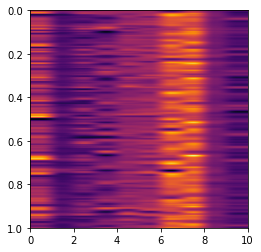

In [19]:
import matplotlib.pyplot as plt
imshow(np.array(X_train[5]), cmap=plt.get_cmap('inferno'), extent=[0,10,1,0], aspect=10)

## CNN parameters

In [20]:
# Models parameters
start_filter = 8 #number of filters in the initial block
filter_h = 4 #filter's hight
filter_w = 1 #filter's wide
depth = 5 # number of [conv -> ReLu -> maxpool] blocks
stride_h = 1 #stride's height
stride_w = 1 #stride's width
filter_inc = 1.5 #filter increament coefficient for next CNN block
dense1 = 128 # neurons in the first dense layer
dense2 = 64 # neurons in the second dense layer
dense3 = 32  # neurons in the third dense layer
drop1 = 0.1
drop2 = 0
drop3 = 0
pool_h = 2 #pooling filter's hight
pool_w = 1 #pooling filter's width

# Training parameter
batch_size = [128]
validation_split=0.2
epochs=100
# learning rate
lr = 1e-3

# datest settings
X_train = np.array(X_train)
X_train = np.expand_dims(X_train, axis=-1)  #run only once
y_train = np.array(y_train)
X_train.shape
#Preparing the Test set
X_test = np.array(X_test)
X_test = np.expand_dims(X_test, axis=-1)  # run only once
y_test = np.array(y_test)
# initializing accuracy vector for compute the mean over 3 trials with same parameters
accuracy =  [None] * 3

# CNN TRAIN AND TEST
This code will construct,run the training and testing of the CNN with the parameters described above.
Also it will add a line (Mean accuracy of 3 run with the corrosponding parameters) to an already existent file which is present in your drive.

In [21]:
for index in range(len(batch_size)):
  for times in range(3):
    start_f = start_filter
    model = tf.keras.Sequential()
# Features extraction
    for i in range(depth):

        if i == 0:
          input_shape = [X_train[0].shape[0], X_train[0].shape[1], 1] #i'm specifieng the input shape only for the first step
        else:
          input_shape=[None]

# Conv block: Conv2D -> ReLu -> Pooling
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                        kernel_size=(filter_h, filter_w),
                                        strides=(stride_h, stride_w),
                                        padding='same',
                                        input_shape=input_shape))
        model.add(tf.keras.layers.ReLU()) #it's the activation step # try with differents ReLu
        model.add(tf.keras.layers.MaxPool2D(pool_size=(pool_h, pool_w))) # (2,1) to not mix up the channels
        start_f = int(filter_inc*start_f) # i'm increasing the number of filters for the next block

# Classifier
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=dense1, activation='relu'))
    model.add(tf.keras.layers.Dropout(drop1))
    model.add(tf.keras.layers.Dense(units=dense2, activation='relu'))
    model.add(tf.keras.layers.Dropout(drop2))
    model.add(tf.keras.layers.Dense(units=dense3, activation='relu'))
    model.add(tf.keras.layers.Dropout(drop3))
    model.add(tf.keras.layers.Dense(units=8, activation='softmax'))

# Visualize initialized weights
    model.weights
# Loss
    loss = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr) #Adam used to optimize the learning rate at each step
# Metrics
    metrics = ['accuracy']
# Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# Train the model
    history = model.fit(x=X_train, y=y_train, batch_size = batch_size[index], validation_split=validation_split, epochs=epochs)

# Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    results = model.evaluate(X_test, y_test, batch_size=32)
    print("test loss, test acc:", results)
    accuracy[times] = round(results[1],4)
  
  MeanAccuracy = sum(accuracy)/3
  print("Mean accuracy:", MeanAccuracy)
# Write in a .csv file the parameters used and the accuracy obtained
  parameters =[MeanAccuracy, batch_size[index], validation_split, epochs, lr, start_filter, filter_h, filter_w, depth, stride_h, stride_w, dense1, dense2, dense3, drop1, drop2, drop3, pool_h, pool_w, filter_inc, duration, overlapping, n, m ]
  import csv
  with open('/content/drive/My Drive/parameters_signal_s'+str(n)+'d'+str(m)+'.csv', mode='a') as parameter_file:
      parameter_writer = csv.writer(parameter_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      parameter_writer.writerow(parameters)

Epoch 1/100
39/39 [==============================] - 2s 43ms/step - loss: 2.0554 - accuracy: 0.1622 - val_loss: 1.8581 - val_accuracy: 0.2447
Epoch 2/100
39/39 [==============================] - 1s 31ms/step - loss: 1.2109 - accuracy: 0.4869 - val_loss: 0.5077 - val_accuracy: 0.8079
Epoch 3/100
39/39 [==============================] - 1s 30ms/step - loss: 0.3925 - accuracy: 0.8475 - val_loss: 0.2728 - val_accuracy: 0.9163
Epoch 4/100
39/39 [==============================] - 1s 30ms/step - loss: 0.2210 - accuracy: 0.9171 - val_loss: 0.2805 - val_accuracy: 0.9072
Epoch 5/100
39/39 [==============================] - 1s 31ms/step - loss: 0.1810 - accuracy: 0.9306 - val_loss: 0.2019 - val_accuracy: 0.9483
Epoch 6/100
39/39 [==============================] - 1s 31ms/step - loss: 0.1406 - accuracy: 0.9450 - val_loss: 0.1776 - val_accuracy: 0.9483
Epoch 7/100
39/39 [==============================] - 1s 31ms/step - loss: 0.1104 - accuracy: 0.9567 - val_loss: 0.1621 - val_accuracy: 0.9647
Epoch 

## Saving results of best 10 parameters combination in CSV file in Drive

In [22]:
#parameters_signal = pd.read_csv('/content/drive/My Drive/parameters_signal_s1d1.csv')
#parameters_signal = parameters_signal.sort_values(by='Mean_Accuracy', ascending=False)
#parameters_signal = pd.DataFrame.reset_index(parameters_signal)
#best_10 = parameters_signal.iloc[:10,:]
#best_10.to_csv('/content/drive/My Drive/CNN_signal_best10_para_s1d1.csv', index=False)
#best_10.head(10)